In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = Path("games_info_and_reviews.csv")
games_df = pd.read_csv(path)
# Review the DataFrame
games_df.head()

,game_id,game_name,is_free,genres,categories,release_date,price,required_age,review_score_desc,total_positive_reviews,total_negative_reviews,review_score,owners
0,1744330,No More Heroes 3,False,Action,"Single-player, Steam Achievements, Full contro...","11 Oct, 2022",CDN$ 49.99,17,Very Positive,232,46,8,"20,000 .. 50,000"
1,1743380,SCP: Doki Doki Anomaly,False,"Indie, RPG","Single-player, Steam Achievements","7 Oct, 2021",CDN$ 6.69,0,Very Positive,51,4,8,"0 .. 20,000"
2,1742450,西游记2021,False,"Adventure, Casual, Indie, RPG, Strategy",Single-player,"30 Sep, 2021",CDN$ 11.49,0,No user reviews,0,0,0,"50,000 .. 100,000"
3,1742470,My Newborn Life In A Harem,False,"Casual, RPG",Single-player,"29 Mar, 2022",CDN$ 14.49,0,Mixed,18,12,5,"0 .. 20,000"
4,1742500,My Dear Frankenstein -English Edition-,False,Adventure,Single-player,"30 Sep, 2021",CDN$ 5.69,0,4 user reviews,4,0,0,"0 .. 20,000"


In [4]:
print(games_df.dtypes)

game_id                    int64
game_name                 object
is_free                     bool
genres                    object
categories                object
release_date              object
price                     object
required_age              object
review_score_desc         object
total_positive_reviews     int64
total_negative_reviews     int64
review_score               int64
owners                    object
dtype: object


In [6]:
# One-hot encode categorical columns
encoded_df = pd.get_dummies(games_df, columns=['genres', 'categories', 'review_score_desc'])


In [7]:
print(encoded_df.dtypes)

game_id                                       int64
game_name                                    object
is_free                                        bool
release_date                                 object
price                                        object
                                              ...  
review_score_desc_Overwhelmingly Negative     uint8
review_score_desc_Overwhelmingly Positive     uint8
review_score_desc_Positive                    uint8
review_score_desc_Very Negative               uint8
review_score_desc_Very Positive               uint8
Length: 2521, dtype: object


In [9]:
encoded_df.columns

Index(['game_id', 'game_name', 'is_free', 'release_date', 'price',
       'required_age', 'total_positive_reviews', 'total_negative_reviews',
       'review_score', 'owners',
       ...
       'review_score_desc_Mixed', 'review_score_desc_Mostly Negative',
       'review_score_desc_Mostly Positive', 'review_score_desc_Negative',
       'review_score_desc_No user reviews',
       'review_score_desc_Overwhelmingly Negative',
       'review_score_desc_Overwhelmingly Positive',
       'review_score_desc_Positive', 'review_score_desc_Very Negative',
       'review_score_desc_Very Positive'],
      dtype='object', length=2521)

In [11]:
num_rows, num_columns = encoded_df.shape

print(f"Number of columns,rows in the encoded DataFrame: {num_columns},{num_rows}")


Number of columns,rows in the encoded DataFrame: 2521,11968


In [16]:
print(encoded_df['price'].unique())


['CDN$ 49.99' 'CDN$ 6.69' 'CDN$ 11.49' 'CDN$ 14.49' 'CDN$ 5.69'
 'CDN$ 8.99' 'CDN$ 8.09' 'CDN$ 2.59' 'CDN$ 22.79' 'CDN$ 1.44' 'CDN$ 4.65'
 'CDN$ 6.50' 'CDN$ 1.19' 'CDN$ 7.99' 'CDN$ 3.39' 'CDN$ 13.99' 'CDN$ 4.99'
 'CDN$ 10.49' 'CDN$ 226.99' 'CDN$ 19.49' 'CDN$ 15.49' 'CDN$ 17.49'
 'CDN$ 12.99' 'CDN$ 2.67' 'CDN$ 1.67' 'CDN$ 5.19' 'CDN$ 1.29' 'CDN$ 2.29'
 'CDN$ 0.77' 'CDN$ 3.89' 'CDN$ 56.99' 'CDN$ 29.99' 'CDN$ 10.29'
 'CDN$ 13.49' 'CDN$ 11.79' 'CDN$ 18.19' 'CDN$ 18.49' 'CDN$ 8.34'
 'CDN$ 6.49' 'CDN$ 44.99' 'CDN$ 17.99' 'CDN$ 28.99' 'CDN$ 14.99'
 'CDN$ 7.79' 'CDN$ 6.99' 'CDN$ 1.16' 'CDN$ 22.99' 'CDN$ 16.99'
 'CDN$ 10.00' 'CDN$ 24.79' 'CDN$ 4.50' 'CDN$ 0.90' 'CDN$ 13.64'
 'CDN$ 259.99' 'CDN$ 5.35' 'CDN$ 51.99' '₩ 77,000' 'CDN$ 54.99' '¥ 158.00'
 'CDN$ 1.70' 'CDN$ 11.99' 'CDN$ 1.62' 'CDN$ 20.79' 'CDN$ 1.55'
 'CDN$ 45.49' 'CDN$ 21.79' 'CDN$ 51.49' 'CDN$ 5.79' 'CDN$ 0.64'
 'CDN$ 19.99' 'CDN$ 25.99' 'CDN$ 0.72' 'CDN$ 6.24' 'CDN$ 4.37'
 'CDN$ 79.99' 'CDN$ 33.99' 'CDN$ 42.00' 'CDN$ 17.22' 'CDN$ 39

In [25]:
# Replace empty strings with NaN (missing value)
encoded_df['price'] = encoded_df['price'].replace('', np.nan)

In [27]:
# Replace non-numeric characters with empty strings
encoded_df['price'] = encoded_df['price'].str.replace(r'[^0-9.]', '', regex=True)

# Convert the column to float, coercing errors to NaN
encoded_df['price'] = pd.to_numeric(encoded_df['price'], errors='coerce')


In [28]:
# Import MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Specify the numerical columns to scale
numerical_columns = ['price', 'total_positive_reviews', 'total_negative_reviews', 'review_score']

# Apply MinMax scaling to the numerical columns
encoded_df[numerical_columns] = scaler.fit_transform(encoded_df[numerical_columns])


C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49496 (\N{HANGUL SYLLABLE SYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20882 (\N{CJK UNIFIED IDEOGRAPH-5192}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:

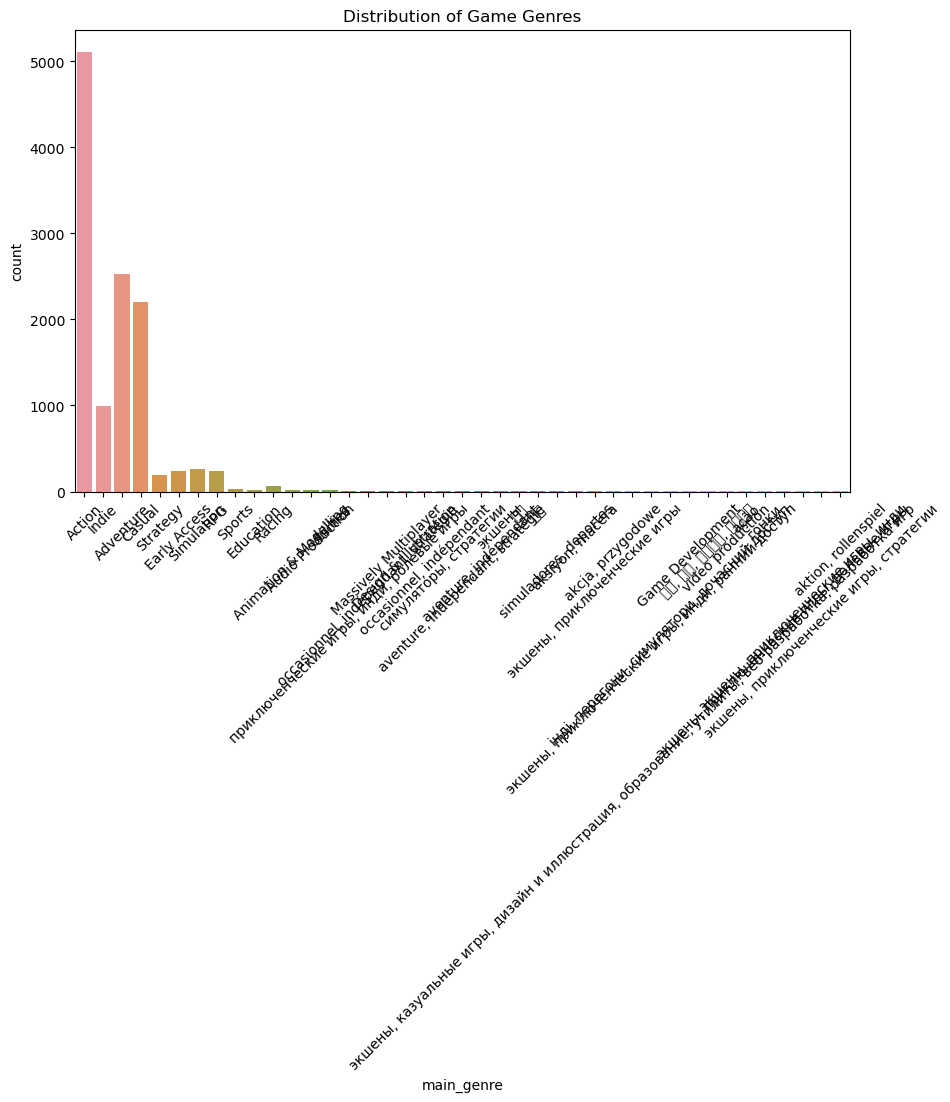

In [45]:


# Visualize genre distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=games_df, x='main_genre')
plt.xticks(rotation=45)
plt.title('Distribution of Game Genres')
plt.show()


In [39]:
def categorize_genre(genre):
    # Convert the genre to lowercase for case-insensitive matching
    genre = genre.lower()
    
    # Define categories based on the first word or specific keywords in the genre
    if 'action' in genre:
        return 'Action'
    elif 'adventure' in genre:
        return 'Adventure'
    elif 'animation' in genre or 'modelling' in genre:
        return 'Animation & Modelling'
    elif 'audio production' in genre:
        return 'Audio Production'
    elif 'casual' in genre:
        return 'Casual'
    elif 'design' in genre or 'illustration' in genre:
        return 'Design & Illustration'
    elif 'early access' in genre:
        return 'Early Access'
    elif 'education' in genre:
        return 'Education'
    elif 'game development' in genre:
        return 'Game Development'
    elif 'indie' in genre:
        return 'Indie'
    elif 'massively multiplayer' in genre:
        return 'Massively Multiplayer'
    elif 'racing' in genre:
        return 'Racing'
    elif 'rpg' in genre:
        return 'RPG'
    elif 'simulation' in genre:
        return 'Simulation'
    elif 'sports' in genre:
        return 'Sports'
    elif 'strategy' in genre:
        return 'Strategy'
    elif 'utilities' in genre:
        return 'Utilities'
    else:
        # If the genre doesn't match any predefined category, return it unchanged
        return genre

# Apply the function to the 'genres' column in your DataFrame
games_df['main_genre'] = games_df['genres'].apply(categorize_genre)
games_df

,game_id,game_name,is_free,genres,categories,release_date,price,required_age,review_score_desc,total_positive_reviews,total_negative_reviews,review_score,owners,main_genre
0,1744330,No More Heroes 3,False,Action,"Single-player, Steam Achievements, Full contro...","11 Oct, 2022",CDN$ 49.99,17,Very Positive,232,46,8,"20,000 .. 50,000",Action
1,1743380,SCP: Doki Doki Anomaly,False,"Indie, RPG","Single-player, Steam Achievements","7 Oct, 2021",CDN$ 6.69,0,Very Positive,51,4,8,"0 .. 20,000",Indie
2,1742450,西游记2021,False,"Adventure, Casual, Indie, RPG, Strategy",Single-player,"30 Sep, 2021",CDN$ 11.49,0,No user reviews,0,0,0,"50,000 .. 100,000",Adventure
3,1742470,My Newborn Life In A Harem,False,"Casual, RPG",Single-player,"29 Mar, 2022",CDN$ 14.49,0,Mixed,18,12,5,"0 .. 20,000",Casual
4,1742500,My Dear Frankenstein -English Edition-,False,Adventure,Single-player,"30 Sep, 2021",CDN$ 5.69,0,4 user reviews,4,0,0,"0 .. 20,000",Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11963,282070,This War of Mine,False,"Adventure, Indie, Simulation","Single-player, Steam Achievements, Steam Tradi...","14 Nov, 2014",฿400.00,0,Very Positive,17395,1300,8,"2,000,000 .. 5,000,000",Adventure
11964,703870,Make a word!,False,"Casual, Indie","Single-player, Steam Achievements","29 Sep, 2017","2,99€",0,Mostly Positive,23,8,6,"50,000 .. 100,000",Casual
11965,1599660,Sackboy™: A Big Adventure,False,Adventure,"Single-player, Multi-player, Co-op, Online Co-...","27 Oct, 2022",CDN$ 39.99,0,Very Positive,789,132,8,"50,000 .. 100,000",Adventure
11966,359550,Tom Clancy's Rainbow Six® Siege,False,Action,"Single-player, Multi-player, PvP, Online PvP, ...","1 Dec, 2015","₩ 22,000",0,Very Positive,425174,66735,8,"20,000,000 .. 50,000,000",Action


In [41]:
# Find unique values in the 'main_genre' column
unique_genres = games_df['main_genre'].unique()

# Print the unique genres
print("Unique genres:")
for genre in unique_genres:
    print(genre)


Unique genres:
Action
Indie
Adventure
Casual
Strategy
Early Access
Simulation
RPG
Sports
Education
Racing
Animation & Modelling
Audio Production
Utilities
приключенческие игры, инди, ролевые игры
occasionnel, indépendant, stratégie
Massively Multiplayer
Design & Illustration
occasionnel, indépendant
симуляторы, стратегии
aventure, indépendant, stratégie
aventure, indépendant
экшены
액션
动作
simuladores, deportes
aksiyon, macera
экшены, приключенческие игры
akcja, przygodowe
экшены, казуальные игры, дизайн и иллюстрация, образование, утилиты, веб-разработка, разработка игр
экшены, приключенческие игры, инди, ранний доступ
інді, перегони, симулятори, дочасний доступ
Game Development
冒險, 休閒, 獨立製作, 角色扮演
video production
ação
гонки
экшены, приключенческие игры, ролевые игры
экшены, приключенческие игры, инди
экшены, приключенческие игры, стратегии
aktion, rollenspiel


In [50]:
# Apply the categorization function to the 'genres' column
games_df['main_genre'] = games_df['genres'].apply(categorize_genre)

# Count the number of games for each main genre
genre_counts = games_df['main_genre'].value_counts()

# Display the count of games for each main genre
print(genre_counts)


Action                                                                                                 5114
Adventure                                                                                              2529
Casual                                                                                                 2201
Indie                                                                                                   992
Simulation                                                                                              264
Early Access                                                                                            240
RPG                                                                                                     235
Strategy                                                                                                187
Racing                                                                                                   70
Sports                      

In [48]:
def categorize_main_genre(genres):
    # Define categories based on the first word or specific keywords in the genre
    if genres.startswith('Action, '):
        return 'Action'
    elif genres.startswith('Adventure, '):
        return 'Adventure'
    elif genres.startswith('Animation & Modelling, '):
        return 'Animation & Modelling'
    elif genres.startswith('Audio Production, '):
        return 'Audio Production'
    elif genres.startswith('Casual, '):
        return 'Casual'
    elif genres.startswith('Design & Illustration, '):
        return 'Design & Illustration'
    elif genres.startswith('Early Access, '):
        return 'Early Access'
    elif genres.startswith('Education, '):
        return 'Education'
    elif genres.startswith('Game Development, '):
        return 'Game Development'
    elif genres.startswith('Indie, '):
        return 'Indie'
    elif genres.startswith('Massively Multiplayer, '):
        return 'Massively Multiplayer'
    elif genres.startswith('Racing, '):
        return 'Racing'
    elif genres.startswith('RPG, '):
        return 'RPG'
    elif genres.startswith('Simulation, '):
        return 'Simulation'
    elif genres.startswith('Sports, '):
        return 'Sports'
    elif genres.startswith('Strategy, '):
        return 'Strategy'
    elif genres.startswith('Utilities, '):
        return 'Utilities'
    else:
        return 'Other'  # If the genre doesn't match any predefined category, tag it as 'Other'

# Apply the function to the 'genres' column in your DataFrame
games_df['main_genre'] = games_df['genres'].apply(categorize_main_genre)
